# Imports



In [1]:
pip install columnar #package to print table of data 

In [2]:
from collections import defaultdict
import sys
import math
import time
import heapq
import gc
import zipfile
from time import perf_counter_ns
import os
import matplotlib.pyplot as plt
from columnar import columnar
import random
import copy
from tabulate import tabulate


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
with zipfile.ZipFile('/content/drive/MyDrive/tsp_dataset.zip', 'r') as zip_ref:

     zip_ref.extractall('/content/')

# Classes and handy functions

In this section we define some useful classes and functions for our algorithm implementations.

## Data structures

In [5]:
class Graph():
  def __init__ (self):
    self.V=[]
    self.E= defaultdict(list)
    self.adjacency_list = defaultdict(list)

  def add_vertex(self,v):
    self.V.append(v)

  def remove_vertex (self,v):
    self.V.remove(v)

  def add_edge(self, source_node, destination_node, weight):
    # First case
    # We add the source and the destination node only if the are not already present
    if (source_node not in self.V):
      self.V.append(source_node)
    
    if (destination_node not in self.V):
      self.V.append(destination_node)
    
    # Now we can add the edge
    #edge = (source_node.vertex, destination_node.vertex, weight)
    self.E[(source_node,destination_node)] = weight

    # Now we update the graph
    self.adjacency_list[source_node].append((destination_node,weight))
    if (source_node != destination_node):
      self.adjacency_list[destination_node].append((source_node,weight))

  def get_edge(self, v1,v2):
    if((v1,v2) in self.E):
      return self.E.get((v1,v2))
    else:
      return self.E.get((v2,v1))
      

In [6]:
def convert_to_rad(x): # radians conversion
  PI = 3.141592
  deg = x
  min = x- deg
  rad = PI * (deg + 5.0 * min/ 3.0) / 180.0
  return rad

In [7]:
class Point():
  def __init__(self,v,x,y):
    self.vertex=v
    self.x = x
    self.y = y
  
  def get_x(self):
    return self.x

  def get_y(self):
    return self.y

  def __repr__(self):
    return str(self.vertex)+":("+str(self.x)+", "+str(self.y)+")"

  def __str__(self):
    return str(self.vertex)+":("+str(self.x)+", "+str(self.y)+")"


In [8]:
def compute_weight(weight_type, u,v):
  # Compute the euclidean distance, then round to the nearest integer
  if (weight_type=="EUC_2D"):
    dis = math.floor(math.sqrt(math.pow((v.x-u.x),2)+math.pow((v.y-u.y),2)))
    return dis
  elif (weight_type =="GEO"):
    # Convert x, y coordinates to radians using the code specified in the TSPLIB FAQ.
    # The formula uses the integer part of x and y (DOES NOT ROUND TO THE NEAREST INTEGER).

    PI = 3.141592
        
    rad_ux = convert_to_rad(u.x)
    rad_vx = convert_to_rad(v.x)
    rad_uy = convert_to_rad(u.y)
    rad_vy = convert_to_rad(v.y)
                             
    RRR = 6378.388
    
    q1 = math.cos(rad_uy - rad_vy)
    q2 = math.cos(rad_ux - rad_vx)
    q3 = math.cos(rad_ux + rad_vx)
    
    dij = (int) ( RRR * math.acos( 0.5*((1.0+q1)*q2 - (1.0-q1)*q3) ) + 1.0)
    return dij 

## Reading data

In [9]:
def read_input_data(filepath):
  f = open(filepath, "r")
  lines = f.readlines()
  data =[]
  for index, line in enumerate (lines):
    text = line.strip()
    data.append(float(text))
  return data

In [10]:
def read_sizes(filepath):
  f = open(filepath, "r")
  lines = f.readlines()
  data =[]
  for index, line in enumerate (lines):
    text = line.strip()
    data.append(int(text))
  return data

In [11]:
def read_files(filepath):
  f = open(filepath, "r")
  lines = f.readlines()
  data =[]
  for index, line in enumerate (lines):
    text = line.strip()   
    data.append(text)
  return data

In [12]:
def take_integer(number):
  splitted_number = number.split('.')
  return int(splitted_number[0])

In [13]:
def get_optimal_solution(filename):
  if filename == "burma14.tsp":
    return 3323
  if filename == "ulysses16.tsp":
    return 6859
  if filename == "ulysses22.tsp":
    return 7013
  if filename == "eil51.tsp":
    return 426
  if filename == "berlin52.tsp":
    return 7542
  if filename == "kroD100.tsp":
    return 21294
  if filename == "kroA100.tsp":
    return 21282
  if filename == "ch150.tsp":
    return 6528
  if filename == "gr202.tsp":
    return 40160
  if filename == "gr229.tsp":
    return 134602
  if filename == "pcb442.tsp":
    return 50778 
  if filename == "d493.tsp":
    return 35002
  if filename == "dsj1000.tsp":
    return 18659688 

In [14]:
def read_input_graph(filepath):
  f = open(filepath, "r")
  lines = f.readlines()
  save_coordinate= False
  weight_type = ""
  graph = Graph()
  space_points =[]
  for index, line in enumerate (lines):
    text = line.strip()
    text_splitted = text.split()
    if ("EOF" in text):
      break
    if ("DIMENSION" in text):
      for dim in text_splitted:
        if (dim.isdigit()):
          size = dim
    elif ("EDGE_WEIGHT_TYPE" in text):
      if ("GEO" in text):
        weight_type = "GEO"
      elif ("EUC_2D" in text):
        weight_type = "EUC_2D"
    elif ("NODE_COORD_SECTION" in text):
      save_coordinate = True
      continue
    elif ("EOF" in text):
      save_coordinate = False
    if (save_coordinate):
      if weight_type=="GEO":
        p = Point(int(text_splitted[0]),take_integer(text_splitted[1]),take_integer(text_splitted[2]))
      elif (weight_type=="EUC_2D"):
        p = Point(int(text_splitted[0]),float(text_splitted[1]),float(text_splitted[2]))
      space_points.append(p)
  
  f.close()
  return graph,int(size),weight_type,space_points

## Functions for TSP

In [15]:
# Computes weight of hamilton cycle found by the approximation algorithm
def weight_hamilton_cycle(graph,hamilton_cycle):
  weight = 0
  for i in range(len(hamilton_cycle)-1):
    edge_weight = graph.get_edge(hamilton_cycle[i],hamilton_cycle[i+1])
    weight += edge_weight
  return weight
  

In [16]:
def prim(graph, starting_vertex):

    mst = defaultdict(set) # We'll save the minimum spanning tree here
    heap = []
    keys =[]
    for i in range(len(graph)+1):
      keys.append(1e6)
    keys[int(starting_vertex)] = 0
    #Let's now initialize our heap structure
    for adjacent_vertex,weight in graph.get(starting_vertex):
       # each heap node contains the edge's weight and the two incident vertices
      heap.append((int(weight), starting_vertex, adjacent_vertex))
    heapq.heapify(heap) 

    while heap: #iterates until heap is empty
        weight, vertex, adj_vertex = heapq.heappop(heap) #extracts minimum node from the heap
       
        if keys[int(adj_vertex)]== 1e6 and weight < keys[int(adj_vertex)]:
            mst[vertex].add((adj_vertex,weight))
            keys[int(adj_vertex)] = weight

            for next_vertex, weight in graph.get(adj_vertex):

                if keys[int(next_vertex)]== 1e6 :
                    heapq.heappush(heap, (int(weight), adj_vertex, next_vertex))
                   

    return mst

In [17]:
# Computes error rate of approximate solution given optimal
def compute_error(optimal, approx_solution):
  return (approx_solution- optimal)/optimal 

In [18]:
def measure_run_time(num_iterations,input_directory,weights,algorithm,errors):
  sum_times = 0.0
  sizes = []
  avg_run_times = []
  files = []
  for file in (os.listdir(input_directory)):
    print("------------------------------------------------------------------------")
    file_path = f"{input_directory}/{file}"
    graph,size,weight_type,space_points = read_input_graph(file_path)
    files.append(file)
    for i in range(len(space_points)):
      u=space_points[i]
      for j in range(i+1,len(space_points)):
        v=space_points[j]
        weight = compute_weight(weight_type,u,v)
        graph.add_edge(u.vertex,v.vertex,weight)
    print(f"Reading file {file}")
    gc.disable()
    for i in range(num_iterations):
      start_time = perf_counter_ns()
      cycle = algorithm(graph)
      end_time = perf_counter_ns()
      sum_times += (end_time-start_time)
    solution = weight_hamilton_cycle(graph,cycle)
    weights.append(solution) #weight of the hamiltonian cycle
    optimal = get_optimal_solution(file)
    errors.append(compute_error(optimal,solution)) # error rate
    sizes.append(size)
    gc.enable()
    time = ((end_time - start_time)/num_iterations) #running time
    avg_run_times.append(time)
    print(f"Total weight using {algorithm}: {solution}, in {time} ns")

  return avg_run_times,sizes,files



# Input reading
This section is to open one file at a time and to check whether the triangle inequality holds

In [ ]:
graph,size,weight_type,space_points= read_input_graph('/content/tsp_dataset/eil51.tsp')

for i in range(len(space_points)):
  u=space_points[i]
  for j in range(i+1,len(space_points)):
    v=space_points[j]
    weight = compute_weight(weight_type,u,v)
    graph.add_edge(u.vertex,v.vertex,weight)

print("Graph initialized!")

Graph initialized!


Let's check whether our weights respect the triangle inequality

In [ ]:
triangle_inequality = True

for i in range(len(space_points)):
  if triangle_inequality:
    break
  u = space_points[i]
  for j in range(i+1,len(space_points)):
    if not triangle_inequality:
      break
    v = space_points[j]
    weight_uv = compute_weight(weight_type,u,v)
    for k in range(i+2,len(space_points)):
      if (not triangle_inequality):
        break
      w = space_points[k]
      weight_uw = compute_weight(weight_type,u,w)
      weight_vw = compute_weight(weight_type,v,w)
      if (weight_uv> (weight_uw + weight_vw)):
        print(f"U:{u}, V:{v}, W:{w}, {weight_uv}>{weight_uw + weight_vw}")
        print("Triangle inequality is not respected")
        break
        triangle_inequality=False

if (triangle_inequality):
  print("Triangle inequality is respected")

Triangle inequality is respected


In [ ]:
graph.V

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [ ]:
graph.E.items()

dict_items([((1, 2), 535), ((1, 3), 487), ((1, 4), 348), ((1, 5), 1063), ((1, 6), 716), ((1, 7), 614), ((1, 8), 112), ((1, 9), 1002), ((1, 10), 688), ((1, 11), 2228), ((1, 12), 439), ((1, 13), 439), ((1, 14), 456), ((1, 15), 633), ((1, 16), 142), ((1, 17), 351), ((1, 18), 348), ((1, 19), 646), ((1, 20), 565), ((1, 21), 565), ((1, 22), 209), ((2, 3), 141), ((2, 4), 427), ((2, 5), 1586), ((2, 6), 1247), ((2, 7), 1138), ((2, 8), 572), ((2, 9), 1465), ((2, 10), 1130), ((2, 11), 2745), ((2, 12), 965), ((2, 13), 965), ((2, 14), 990), ((2, 15), 1155), ((2, 16), 606), ((2, 17), 207), ((2, 18), 427), ((2, 19), 1122), ((2, 20), 1036), ((2, 21), 1036), ((2, 22), 416), ((3, 4), 479), ((3, 5), 1550), ((3, 6), 1180), ((3, 7), 1061), ((3, 8), 549), ((3, 9), 1358), ((3, 10), 1022), ((3, 11), 2657), ((3, 12), 893), ((3, 13), 893), ((3, 14), 933), ((3, 15), 1119), ((3, 16), 528), ((3, 17), 239), ((3, 18), 479), ((3, 19), 1023), ((3, 20), 938), ((3, 21), 938), ((3, 22), 425), ((4, 5), 1238), ((4, 6), 991

In [ ]:
graph.adjacency_list.items()

dict_items([(1, [(2, 535), (3, 487), (4, 348), (5, 1063), (6, 716), (7, 614), (8, 112), (9, 1002), (10, 688), (11, 2228), (12, 439), (13, 439), (14, 456), (15, 633), (16, 142), (17, 351), (18, 348), (19, 646), (20, 565), (21, 565), (22, 209)]), (2, [(1, 535), (3, 141), (4, 427), (5, 1586), (6, 1247), (7, 1138), (8, 572), (9, 1465), (10, 1130), (11, 2745), (12, 965), (13, 965), (14, 990), (15, 1155), (16, 606), (17, 207), (18, 427), (19, 1122), (20, 1036), (21, 1036), (22, 416)]), (3, [(1, 487), (2, 141), (4, 479), (5, 1550), (6, 1180), (7, 1061), (8, 549), (9, 1358), (10, 1022), (11, 2657), (12, 893), (13, 893), (14, 933), (15, 1119), (16, 528), (17, 239), (18, 479), (19, 1023), (20, 938), (21, 938), (22, 425)]), (4, [(1, 348), (2, 427), (3, 479), (5, 1238), (6, 991), (7, 917), (8, 291), (9, 1339), (10, 1033), (11, 2513), (12, 745), (13, 745), (14, 725), (15, 823), (16, 487), (17, 240), (18, 1), (19, 983), (20, 906), (21, 906), (22, 143)]), (5, [(1, 1063), (2, 1586), (3, 1550), (4, 123

# 2-Approximation Algorithm


In [19]:
def preorder(visited_nodes, v, mst):
  visited_nodes.append(v)
  if (v in mst.keys()):  # if v is internal to the MST i.e. it's not a leaf
    for u in mst.get(v):
      preorder(visited_nodes,u[0],mst)
  return visited_nodes

In [20]:
def approx_metric_tsp(graph):
  root = graph.V[0]
  mst = prim(graph.adjacency_list,root)
  preordered_nodes = []
  visited_nodes = preorder(preordered_nodes,root,mst)
  visited_nodes.append(visited_nodes[0])
  return visited_nodes #hamiltonian cycle

In [21]:
#cycle_2approx = approx_metric_tsp(graph)
#weight_2approx= weight_hamilton_cycle(graph,cycle_2approx)
#print(f"Hamiltonian cycle found: \n{hamilton_cycle}")
#print(f"Weight: {weight_2approx}")

# Nearest Neighbor



```
# 1. Initialization: start from the single-node path 0
2. Selection: let (v0, . . . , vk ) be the current path. Find the
vertex vk+1 not in the path with minimimun distance from vk ;
3. Insertion: insert vk+1 immediately after vk ;
4. repeat from (2) until all vertices are inserted in the path.
```
O(logn) approximation


In [22]:
def nn_tsp(graph):
    unvisited =graph.V.copy()
    visited = [unvisited[0]]
    ad=[] # list in which we store the adjacency list of current node containing only the unvisited nodes
    while(len(visited) != len(unvisited)):
        current_node = visited [-1]
        ad = [item for item in graph.adjacency_list.get(current_node) if item[0] not in visited] 
        next_node = min(ad,key=lambda t:t[1])[0] #take the adjacent node with minimum distance
        visited.append(next_node)
    visited.append(graph.V[0]) #insert the first node at the end of the cycle
    return visited 

In [23]:
#cycle_nn=nn_tsp(graph)
#print(cycle_nn)

In [24]:
#weight_nn =weight_hamilton_cycle(graph,cycle_nn)
#weight_nn

# Random Insertion






```
1. Initialization: start from the single-node path 0. Find the
vertex j that minimize w (0, j) and build the partial circuit
(0, j);
2. Selection: randomly select a vertex k not in the circuit;
3. Insertion: find the edge {i, j} of the partial circuit that
minimize w (i, k) + w (k, j) − w (i, j) and insert k between i
and j;
4. repeat from (2) until all vertices are inserted in the path
```
O(logn) approximation

In [25]:
def random_insertion(graph):

  # 1. Initialization
  circuit =[]
  unvisited =graph.V.copy()
  starting_node = unvisited[0] #node 0
  # find the vertex that minimizes w(0,j): we look through the weights of the 
  # the starting node's adjacency list, and take the vertex j that corresponds to the  min weight
  j = min(graph.adjacency_list.get(starting_node),key=lambda t:t[1])[0] #returns first element of tuple (vertex,weight)
  # build partial circuit (0,j)
  circuit.append(starting_node)
  circuit.append(j)
  unvisited.remove((starting_node))
  unvisited.remove((j))

  # 2. Selection
  while(len(unvisited)>0):
    k = (random.choice(unvisited))  # randomly select a vertex k not in the circuit
    # 3. Insertion
    # find the edge {i, j} of the partial circuit that minimize w (i, k) + w (k, j) − w (i, j) 
    min_triangular = (-1,-1,1e6)
    for x in range(len(circuit)-1):
      i = circuit[x]
      j = circuit[x+1]
      w1 = graph.get_edge(i,k)
      w2 = graph.get_edge(k,j)
      w3 = graph.get_edge(i,j)

      if ((w1+w2-w3)<min_triangular[2]): # look for minimum inequality
        min_triangular = (x,x+1,(w1+w2-w3))

    x = min_triangular[0] #index of i
    y = min_triangular[1] #index of j
    # insert k between i and j
    circuit.insert(x+1,k)
    unvisited.remove(k)
  circuit.append(starting_node)
  return circuit


In [26]:
#cycle_random_insertion = random_insertion(graph)
#cycle_random_insertion

In [27]:
#weight_random_insertion = weight_hamilton_cycle(graph,cycle_random_insertion)
#weight_random_insertion

# Metrics
In this section we compute the algorithms' running times and compare the results.

## Performance Computations

We run each algorithm for 1000 iterations on each graph, and we store its average running times in nanoseconds, its error rate and the solution found. 

In [ ]:
num_iterations = 1000
input_directory = '/content/tsp_dataset'
weights_2approx =[]
errors_2approx = []
weights_nn = []
errors_nn =[]
weights_rand_ins = []
errors_rand_ins =[]


### 2-approx

Runtime measures for 2-approx. algorithm:

In [ ]:
avg_runtimes_2approx,sizes,files = measure_run_time(num_iterations,input_directory,weights_2approx,approx_metric_tsp,errors_2approx)

------------------------------------------------------------------------
Reading file berlin52.tsp
Total weight using <function approx_metric_tsp at 0x7f95c5de4c20>: 10341, in 2684.67 ns
------------------------------------------------------------------------
Reading file burma14.tsp
Total weight using <function approx_metric_tsp at 0x7f95c5de4c20>: 3835, in 156.514 ns
------------------------------------------------------------------------
Reading file ch150.tsp
Total weight using <function approx_metric_tsp at 0x7f95c5de4c20>: 8783, in 24108.37 ns
------------------------------------------------------------------------
Reading file d493.tsp
Total weight using <function approx_metric_tsp at 0x7f95c5de4c20>: 46227, in 445816.417 ns
------------------------------------------------------------------------
Reading file dsj1000.tsp
Total weight using <function approx_metric_tsp at 0x7f95c5de4c20>: 25734567, in 2938410.894 ns
-----------------------------------------------------------------

In [ ]:
avg_runtimes_2approx

[2684.67,
 156.514,
 24108.37,
 445816.417,
 2938410.894,
 2113.928,
 48458.958,
 72138.427,
 10124.154,
 9383.57,
 363372.583,
 290.551,
 344.582]

In [ ]:
weights_2approx

[10341,
 3835,
 8783,
 46227,
 25734567,
 604,
 52334,
 176287,
 29715,
 27418,
 76723,
 7520,
 8148]

In [ ]:
errors_2approx

[0.3711217183770883,
 0.154077640686127,
 0.34543504901960786,
 0.32069596023084396,
 0.37915312410368274,
 0.41784037558685444,
 0.3031374501992032,
 0.3096907921130444,
 0.3962503524104877,
 0.2875927491312107,
 0.5109496238528497,
 0.09636973319725907,
 0.1618422928846428]

### Nearest Neighbor

Runtime measures for Nearest Neighbor heuristics:

In [ ]:
avg_runtimes_nn, sizes,files = measure_run_time(num_iterations,input_directory,weights_nn,nn_tsp,errors_nn)

------------------------------------------------------------------------
Reading file berlin52.tsp
Total weight using <function nn_tsp at 0x7f9d37c19320>: 8962, in 2025.707 ns
------------------------------------------------------------------------
Reading file burma14.tsp
Total weight using <function nn_tsp at 0x7f9d37c19320>: 4694, in 84.492 ns
------------------------------------------------------------------------
Reading file ch150.tsp
Total weight using <function nn_tsp at 0x7f9d37c19320>: 8259, in 23243.461 ns
------------------------------------------------------------------------
Reading file d493.tsp
Total weight using <function nn_tsp at 0x7f9d37c19320>: 43244, in 639248.013 ns
------------------------------------------------------------------------
Reading file dsj1000.tsp
Total weight using <function nn_tsp at 0x7f9d37c19320>: 24630468, in 6042081.878 ns
------------------------------------------------------------------------
Reading file eil51.tsp
Total weight using <func

In [ ]:
weights_nn

[8962,
 4694,
 8259,
 43244,
 24630468,
 497,
 52774,
 168661,
 27772,
 26906,
 61926,
 9465,
 8056]

In [ ]:
avg_runtimes_nn

[2025.707,
 84.492,
 23243.461,
 639248.013,
 6042081.878,
 1010.894,
 53630.489,
 68024.444,
 7434.701,
 6859.419,
 485099.17,
 62.054,
 125.523]

In [ ]:
errors_nn

[0.18827897109520023,
 0.41257899488414085,
 0.26516544117647056,
 0.23547225872807268,
 0.31998284215684636,
 0.16666666666666666,
 0.31409362549800796,
 0.25303487318167633,
 0.3049525420543182,
 0.26354841739457124,
 0.2195438969632518,
 0.3799387665840502,
 0.14872379865963212]

### Random Insertion

Runtime measures for Random Insertion:

In [ ]:
avg_runtimes_rand_ins, sizes,files = measure_run_time(num_iterations,input_directory,weights_rand_ins,random_insertion,errors_rand_ins)

------------------------------------------------------------------------
Reading file berlin52.tsp
Total weight using <function random_insertion at 0x7f95c5de4440>: 7744, in 1735.297 ns
------------------------------------------------------------------------
Reading file burma14.tsp
Total weight using <function random_insertion at 0x7f95c5de4440>: 3683, in 135.281 ns
------------------------------------------------------------------------
Reading file ch150.tsp
Total weight using <function random_insertion at 0x7f95c5de4440>: 7065, in 16369.733 ns
------------------------------------------------------------------------
Reading file d493.tsp
Total weight using <function random_insertion at 0x7f95c5de4440>: 37899, in 220189.918 ns
------------------------------------------------------------------------
Reading file dsj1000.tsp
Total weight using <function random_insertion at 0x7f95c5de4440>: 20838071, in 1041993.537 ns
---------------------------------------------------------------------

In [ ]:
avg_runtimes_rand_ins

[1735.297,
 135.281,
 16369.733,
 220189.918,
 1041993.537,
 1631.094,
 30972.018,
 41322.109,
 7232.309,
 6893.036,
 175428.627,
 164.434,
 305.635]

In [ ]:
weights_rand_ins

[7744,
 3683,
 7065,
 37899,
 20838071,
 448,
 42890,
 148748,
 21854,
 22246,
 57394,
 7103,
 7416]

In [ ]:
errors_rand_ins

[0.026783346592415803,
 0.10833584110743304,
 0.0822610294117647,
 0.08276669904576882,
 0.11674273439084297,
 0.051643192488262914,
 0.06797808764940239,
 0.10509502087636143,
 0.026877173198007705,
 0.044707429322813935,
 0.13029264642167868,
 0.03557369878991107,
 0.05746470839868815]

##  Importing outputs
We use this section after having saved our performance results into several output files. We get the values from the files so not to run the algorithms again every time.

In [31]:
avg_runtimes_2approx = read_input_data('/content/average_time_2app.txt')
avg_runtimes_2approx

[2684.67,
 156.514,
 24108.37,
 445816.417,
 2938410.894,
 2113.928,
 48458.958,
 72138.427,
 10124.154,
 9383.57,
 363372.583,
 290.551,
 344.582]

In [32]:
errors_2approx = read_input_data('/content/errors_2app.txt')
errors_2approx

[0.3711217183770883,
 0.154077640686127,
 0.34543504901960786,
 0.32069596023084396,
 0.37915312410368274,
 0.41784037558685444,
 0.3031374501992032,
 0.3096907921130444,
 0.3962503524104877,
 0.2875927491312107,
 0.5109496238528497,
 0.09636973319725907,
 0.1618422928846428]

In [33]:
weights_2approx = read_input_data('/content/weights_2app.txt')
weights_2approx

[10341.0,
 3835.0,
 8783.0,
 46227.0,
 25734567.0,
 604.0,
 52334.0,
 176287.0,
 29715.0,
 27418.0,
 76723.0,
 7520.0,
 8148.0]

In [34]:
sizes = read_sizes('/content/sizes.txt')
sizes

[52, 14, 150, 493, 1000, 51, 202, 229, 100, 100, 442, 16, 22]

In [35]:
files = read_files('/content/files.txt')
files

['berlin52.tsp',
 'burma14.tsp',
 'ch150.tsp',
 'd493.tsp',
 'dsj1000.tsp',
 'eil51.tsp',
 'gr202.tsp',
 'gr229.tsp',
 'kroA100.tsp',
 'kroD100.tsp',
 'pcb442.tsp',
 'ulysses16.tsp',
 'ulysses22.tsp']

In [36]:
avg_runtimes_nn = read_input_data('/content/average_time_nn.txt')
avg_runtimes_nn

[2025.707,
 84.492,
 23243.461,
 639248.013,
 6042081.878,
 1010.894,
 53630.489,
 68024.444,
 7434.701,
 6859.419,
 485099.17,
 62.054,
 125.523]

In [37]:
errors_nn = read_input_data('/content/errors_nn.txt')
errors_nn

[0.18827897109520023,
 0.41257899488414085,
 0.26516544117647056,
 0.23547225872807268,
 0.31998284215684636,
 0.16666666666666666,
 0.31409362549800796,
 0.25303487318167633,
 0.3049525420543182,
 0.26354841739457124,
 0.2195438969632518,
 0.3799387665840502,
 0.14872379865963212]

In [38]:
weights_nn = read_input_data('/content/weights_nn.txt')
weights_nn

[8962.0,
 4694.0,
 8259.0,
 43244.0,
 24630468.0,
 497.0,
 52774.0,
 168661.0,
 27772.0,
 26906.0,
 61926.0,
 9465.0,
 8056.0]

In [39]:
avg_runtimes_rand_ins = read_input_data('/content/average_time_rand.txt')
avg_runtimes_rand_ins

[1735.297,
 135.281,
 16369.733,
 220189.918,
 1041993.537,
 1631.094,
 30972.018,
 41322.109,
 7232.309,
 6893.036,
 175428.627,
 164.434,
 305.635]

In [40]:
errors_rand_ins = read_input_data('/content/errors_rand.txt')
errors_rand_ins

[0.026783346592415803,
 0.10833584110743304,
 0.0822610294117647,
 0.08276669904576882,
 0.11674273439084297,
 0.051643192488262914,
 0.06797808764940239,
 0.10509502087636143,
 0.026877173198007705,
 0.044707429322813935,
 0.13029264642167868,
 0.03557369878991107,
 0.05746470839868815]

In [41]:
weights_rand_ins = read_input_data('/content/weights_rand.txt')
weights_rand_ins

[7744.0,
 3683.0,
 7065.0,
 37899.0,
 20838071.0,
 448.0,
 42890.0,
 148748.0,
 21854.0,
 22246.0,
 57394.0,
 7103.0,
 7416.0]

## Tables

We plot a table summarizing our results. In particular, for each algorithm we print the solution (weight of the hamiltonian cycle), the average running time per graph and the error rate. The table is sorted by input size.

In [42]:
#Let's define some useful variables
tuples_2app = sorted(list(zip(sizes,files,errors_2approx,avg_runtimes_2approx,weights_2approx)))
sorted_sizes = sorted(list(list(zip(*tuples_2app))[0]))
sorted_errors_2approx= sorted(list(list(zip(*tuples_2app))[2]))
sorted_runtimes_2approx = sorted(list(list(zip(*tuples_2app))[3]))
sorted_weights_2approx = (list(list(zip(*tuples_2app))[4]))

tuples_nn = sorted(list(zip(sizes,files,errors_nn,avg_runtimes_nn,weights_nn)))
sorted_errors_nn = sorted(list(list(zip(*tuples_nn))[2]))
sorted_runtimes_nn = sorted(list(list(zip(*tuples_nn))[3]))
sorted_weights_nn = (list(list(zip(*tuples_nn))[4]))

tuples_randins = sorted(list(zip(sizes,files,errors_rand_ins,avg_runtimes_rand_ins,weights_rand_ins)))
sorted_errors_randins = sorted(list(list(zip(*tuples_randins))[2]))
sorted_runtimes_randins = sorted(list(list(zip(*tuples_randins))[3]))
sorted_weights_rand_ins = (list(list(zip(*tuples_randins))[4]))


In [43]:
print("\t\t\t       2-approx \t\t\tNearest Neighbor \t\t      Random Insertion")
print("-"*126)
headers = ["Instance","Solution","Time","Error","Solution","Time","Error","Solution","Time","Error"]
data =[]
for i in range(len(sizes)):
  data.append([tuples_2app[i][1],sorted_weights_2approx[i],sorted_runtimes_2approx[i],round(sorted_errors_2approx[i],3),
               sorted_weights_nn[i],sorted_runtimes_nn[i],round(sorted_errors_nn[i],3),
               sorted_weights_rand_ins[i],sorted_runtimes_randins[i],round(sorted_errors_randins[i],3)])


table = tabulate(data,headers,numalign="center",tablefmt = "presto")
print(table)

			       2-approx 			Nearest Neighbor 		      Random Insertion
------------------------------------------------------------------------------------------------------------------------------
 Instance      |  Solution   |    Time     |  Error  |  Solution   |    Time     |  Error  |  Solution   |    Time     |  Error
---------------+-------------+-------------+---------+-------------+-------------+---------+-------------+-------------+---------
 burma14.tsp   |    3835     |   156.514   |  0.096  |    4694     |   62.054    |  0.149  |    3683     |   135.281   |  0.027
 ulysses16.tsp |    7520     |   290.551   |  0.154  |    9465     |   84.492    |  0.167  |    7103     |   164.434   |  0.027
 ulysses22.tsp |    8148     |   344.582   |  0.162  |    8056     |   125.523   |  0.188  |    7416     |   305.635   |  0.036
 eil51.tsp     |     604     |   2113.93   |  0.288  |     497     |   1010.89   |  0.22   |     448     |   1631.09   |  0.045
 berlin52.tsp  |    10341    |   2684.6

Next, we plot each algorithm's results in comparison with the optimal solution

In [44]:
headers = ["File","Optimal","2-Approx","Error","Optimal * 2","approx <= 2*optimal"]
data =[]
for i in range(len(sizes)):
  data.append([tuples_2app[i][1],get_optimal_solution(tuples_2app[i][1]),tuples_2app[i][4],round(tuples_2app[i][2],3),
               get_optimal_solution(tuples_2app[i][1])*2,tuples_2app[i][4]<=2*get_optimal_solution(tuples_2app[i][1])])


table = tabulate(data,headers,numalign="center",tablefmt = "presto")
print(table)
print("-"*90)
print(f"Average error: {sum(errors_2approx)/len(files)}")

 File          |  Optimal  |  2-Approx   |  Error  |  Optimal * 2  | approx <= 2*optimal
---------------+-----------+-------------+---------+---------------+-----------------------
 burma14.tsp   |   3323    |    3835     |  0.154  |     6646      | True
 ulysses16.tsp |   6859    |    7520     |  0.096  |     13718     | True
 ulysses22.tsp |   7013    |    8148     |  0.162  |     14026     | True
 eil51.tsp     |    426    |     604     |  0.418  |      852      | True
 berlin52.tsp  |   7542    |    10341    |  0.371  |     15084     | True
 kroA100.tsp   |   21282   |    29715    |  0.396  |     42564     | True
 kroD100.tsp   |   21294   |    27418    |  0.288  |     42588     | True
 ch150.tsp     |   6528    |    8783     |  0.345  |     13056     | True
 gr202.tsp     |   40160   |    52334    |  0.303  |     80320     | True
 gr229.tsp     |  134602   |   176287    |  0.31   |    269204     | True
 pcb442.tsp    |   50778   |    76723    |  0.511  |    101556     | True
 d493

Comparison of Nearest Neighbor with optimal 

In [45]:
headers = ["File","Optimal","Nearest Neighbor","Error","Optimal * log(n)","approx <= log(n)*optimal"]
data =[]
for i in range(len(sizes)):
  data.append([tuples_nn[i][1],get_optimal_solution(tuples_nn[i][1]),tuples_nn[i][4],round(tuples_nn[i][2],3),
               get_optimal_solution(tuples_nn[i][1])*math.log(tuples_nn[i][0]),
               tuples_nn[i][4]<=math.log2(tuples_nn[i][0])*get_optimal_solution(tuples_nn[i][1])])


table = tabulate(data,headers,numalign="center",tablefmt = "presto")
print(table)
print("-"*110)
print(f"Average error: {sum(errors_nn)/len(files)}")

 File          |  Optimal  |  Nearest Neighbor  |  Error  |  Optimal * log(n)  | approx <= log(n)*optimal
---------------+-----------+--------------------+---------+--------------------+----------------------------
 burma14.tsp   |   3323    |        4694        |  0.413  |      8769.59       | True
 ulysses16.tsp |   6859    |        9465        |  0.38   |      19017.2       | True
 ulysses22.tsp |   7013    |        8056        |  0.149  |      21677.5       | True
 eil51.tsp     |    426    |        497         |  0.167  |      1674.96       | True
 berlin52.tsp  |   7542    |        8962        |  0.188  |      29800.3       | True
 kroA100.tsp   |   21282   |       27772        |  0.305  |      98007.2       | True
 kroD100.tsp   |   21294   |       26906        |  0.264  |      98062.5       | True
 ch150.tsp     |   6528    |        8259        |  0.265  |      32709.4       | True
 gr202.tsp     |   40160   |       52774        |  0.314  |       213180       | True
 gr229.tsp 

Comparison of Random Insertion with optimal 

In [46]:
headers = ["File","Optimal","Random Insertion","Error","Optimal*log(n)","approx <= log(n)*optimal"]
data =[]
for i in range(len(sizes)):
  data.append([tuples_randins[i][1],get_optimal_solution(tuples_randins[i][1]),tuples_randins[i][4],round(tuples_randins[i][2],3),
               get_optimal_solution(tuples_randins[i][1])*math.log(tuples_randins[i][0]),
               tuples_randins[i][4]<=math.log2(tuples_randins[i][0])*get_optimal_solution(tuples_randins[i][1])])


table = tabulate(data,headers,numalign="center",tablefmt = "presto")
print(table)
print("-"*110)
print(f"Average error: {sum(errors_rand_ins)/len(files)}")

 File          |  Optimal  |  Random Insertion  |  Error  |  Optimal*log(n)  | approx <= log(n)*optimal
---------------+-----------+--------------------+---------+------------------+----------------------------
 burma14.tsp   |   3323    |        3683        |  0.108  |     8769.59      | True
 ulysses16.tsp |   6859    |        7103        |  0.036  |     19017.2      | True
 ulysses22.tsp |   7013    |        7416        |  0.057  |     21677.5      | True
 eil51.tsp     |    426    |        448         |  0.052  |     1674.96      | True
 berlin52.tsp  |   7542    |        7744        |  0.027  |     29800.3      | True
 kroA100.tsp   |   21282   |       21854        |  0.027  |     98007.2      | True
 kroD100.tsp   |   21294   |       22246        |  0.045  |     98062.5      | True
 ch150.tsp     |   6528    |        7065        |  0.082  |     32709.4      | True
 gr202.tsp     |   40160   |       42890        |  0.068  |      213180      | True
 gr229.tsp     |  134602   |     

## Plots

In this section we further analyze our algorithms by plotting their running times, their error rate and their weights with respect to the sizes of the input graphs.

Let's first define some useful variables:

Plotting error rates with respect to sizes:

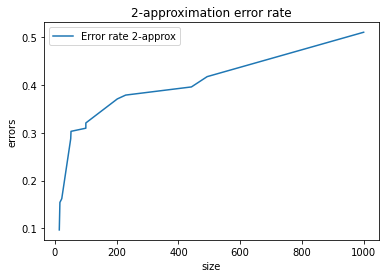

In [47]:
plt.plot(sorted_sizes, sorted_errors_2approx)
plt.legend(["Error rate 2-approx"])
plt.title('2-approximation error rate')
plt.ylabel('errors')
plt.savefig('2app_err_rate.png', dpi=300)
plt.xlabel('size')
plt.show()

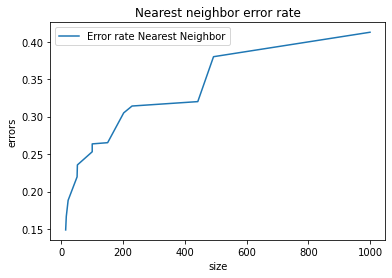

In [48]:
plt.plot(sorted_sizes, sorted_errors_nn)
plt.legend(["Error rate Nearest Neighbor"])
plt.title('Nearest neighbor error rate')
plt.ylabel('errors')
plt.savefig('nn_err_rate.png', dpi=300)
plt.xlabel('size')
plt.show()

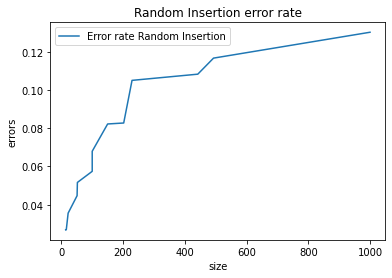

In [49]:
plt.plot(sorted_sizes, sorted_errors_randins)
plt.title('Random Insertion error rate')
plt.legend(["Error rate Random Insertion"])
plt.ylabel('errors')
plt.savefig('rand_ins_err_rate.png', dpi=300)
plt.xlabel('size')
plt.show()

Plotting the algorithms' running times

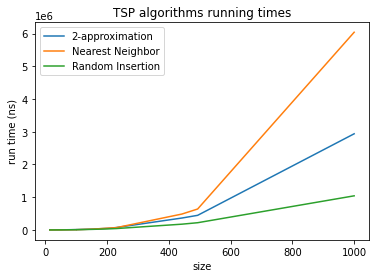

In [50]:
fig,ax = plt.subplots()
ax.plot(sorted_sizes, sorted_runtimes_2approx)
ax.plot(sorted_sizes, sorted_runtimes_nn)
plt.plot(sorted_sizes, sorted_runtimes_randins)
plt.legend(["2-approximation", "Nearest Neighbor","Random Insertion"])
plt.ylabel('run time (ns)')
plt.title("TSP algorithms running times")
plt.xlabel('size')
plt.savefig('tsp_algorithms_comparisons_times.png', dpi=300)
plt.show()

Plotting approximate solutions with respect to optimal:

In [51]:
optimal = []

for file in (list(list(zip(*tuples_nn))[1])):
  optimal.append(get_optimal_solution(file))

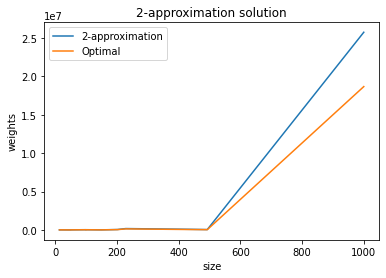

In [52]:
plt.plot(sorted_sizes, sorted_weights_2approx)
plt.plot(sorted_sizes, optimal)
plt.title("2-approximation solution")
plt.legend(["2-approximation","Optimal"])
plt.ylabel('weights')
plt.xlabel('size')
plt.savefig('2app_weights.png', dpi=300)
plt.show()

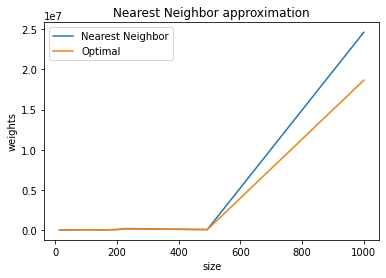

In [53]:
plt.plot(sorted_sizes, sorted_weights_nn)
plt.plot(sorted_sizes, optimal)
plt.title("Nearest Neighbor approximation")
plt.legend(["Nearest Neighbor","Optimal"])
plt.ylabel('weights')
plt.xlabel('size')
plt.savefig('nn_weights.png', dpi=300)
plt.show()

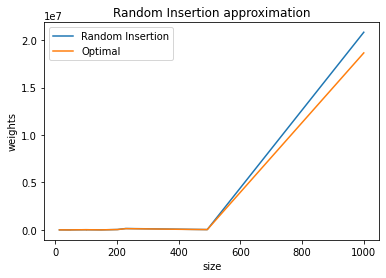

In [54]:
plt.plot(sorted_sizes, sorted_weights_rand_ins)
plt.plot(sorted_sizes, optimal)
plt.title("Random Insertion approximation")
plt.legend(["Random Insertion","Optimal"])
plt.ylabel('weights')
plt.xlabel('size')
plt.savefig('randins_weights.png', dpi=300)
plt.show()

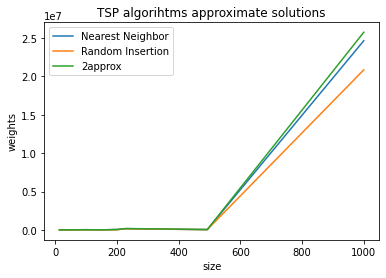

In [55]:
plt.plot(sorted_sizes, sorted_weights_nn)
plt.plot(sorted_sizes, sorted_weights_rand_ins)
plt.plot(sorted_sizes, sorted_weights_2approx)

plt.title("TSP algorihtms approximate solutions")
plt.legend(["Nearest Neighbor","Random Insertion","2approx"])
plt.ylabel('weights')
plt.xlabel('size')
plt.savefig('tsp_algorithms_comparisons_weights.png', dpi=300)
plt.show()